# 線形フィルタ処理いろいろ2


In [1]:
!wget https://github.com/eiichiromomma/CVMLAB/raw/master/img/sample.jpg
!pip install japanize-matplotlib

--2021-06-04 03:45:41--  https://github.com/eiichiromomma/CVMLAB/raw/master/img/sample.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/sample.jpg [following]
--2021-06-04 03:45:42--  https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78522 (77K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  76.68K  --.-KB/s    in 0.02s   

2021-06-04 03:45:42 (3.48 MB/s) - ‘sample.jpg’ saved [78522/78522]

     |████████████████████████████████| 4.1MB 3.9MB/s 
  Cr


## 二次微分フィルタの考え方
単純な差分フィルタを2回畳み込む=差分フィルタを差分フィルタで畳み込む
(filter2Dでは境界条件の指定が必要)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import japanize_matplotlib
kern = np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]], dtype=np.float32)
print('kern=\n', kern)
dst = cv2.filter2D(kern, -1, kern, borderType=cv2.BORDER_ISOLATED)
print('dst=\n', dst)

kern=
 [[ 0.  0.  0.]
 [ 0. -1.  1.]
 [ 0.  0.  0.]]
dst=
 [[ 0.  0.  0.]
 [-1.  2. -1.]
 [ 0.  0.  0.]]


## ラプラシアンフィルタ

Laplacianを使う

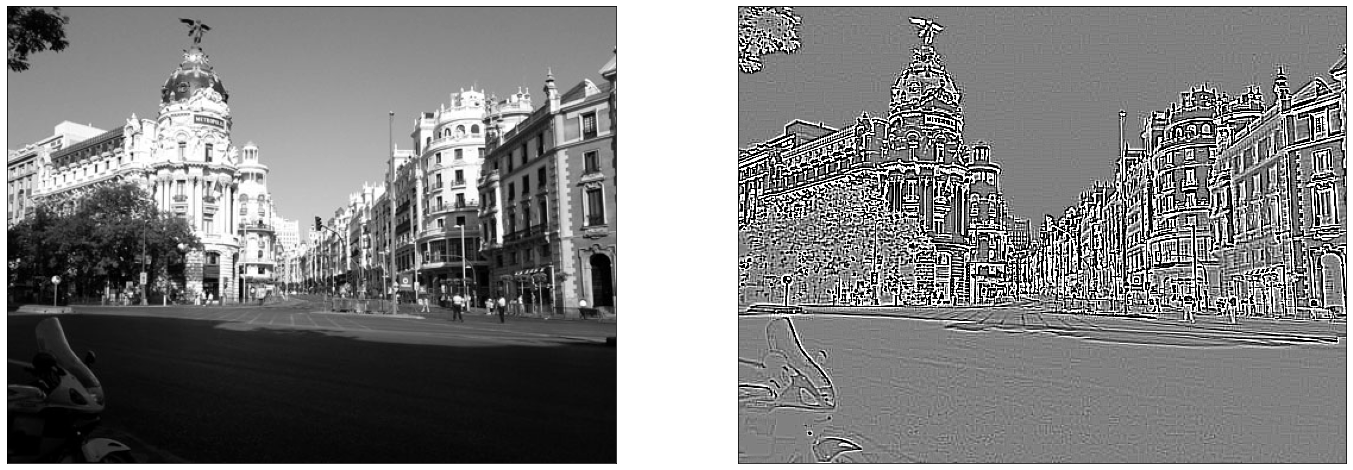

In [3]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)/255.
plt.rc('xtick', bottom=False, labelbottom=False)
plt.rc('ytick', left = False, labelleft = False)
plt.rc('figure', figsize=[24,12])
dst = cv2.Laplacian(gimg, -1, ksize= 3)
plt.subplot(1,2,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray', vmin=-0.5, vmax=0.5)

言うまでもないがノイズには絶望的に弱い

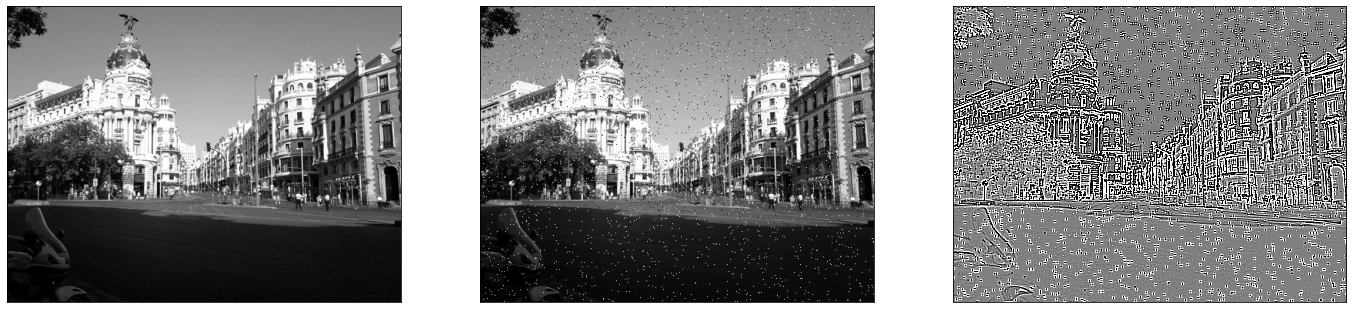

In [4]:
sp_noise = np.random.rand(gimg.shape[0], gimg.shape[1])
pepper = sp_noise < 0.01
salt = sp_noise > 0.99
sp_image = gimg.copy()
sp_image[pepper] = 0
sp_image[salt] = 1.0
dst = cv2.Laplacian(sp_image, -1, ksize= 3)
plt.subplot(1,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(sp_image, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(dst, cmap='gray', vmin=-0.5, vmax=0.5)


## LoGフィルタおよびZero Crossing

OpenCVにはLoGもZero Crossingも拾えないのでscipyを使う

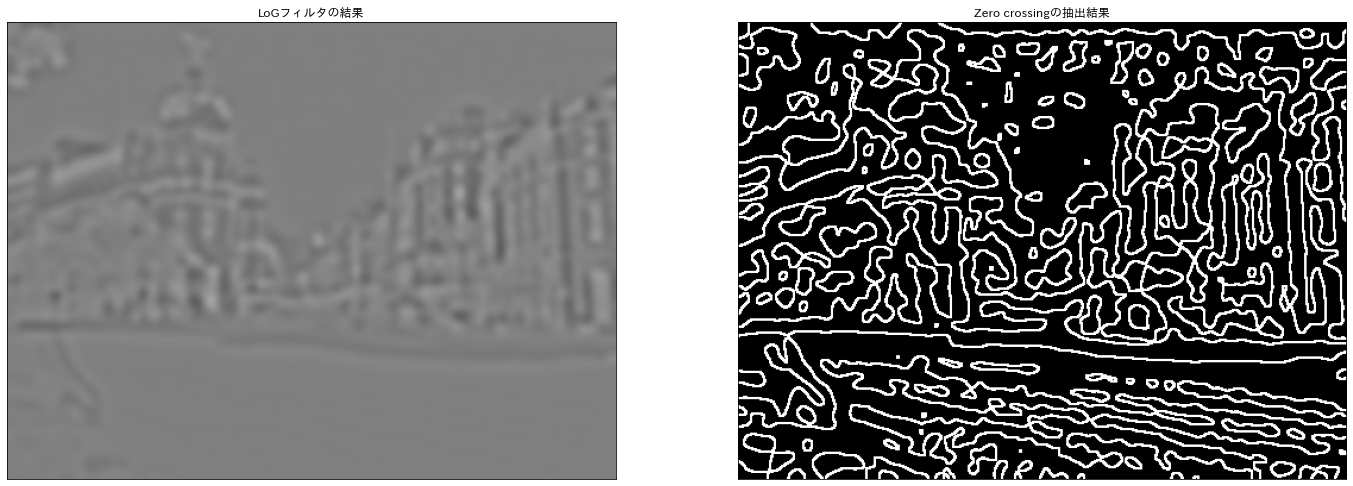

In [5]:
from scipy.ndimage.filters import gaussian_laplace
# SciPyのLoGを使う。出力はsignedにする
logimg = gaussian_laplace(gimg, sigma=5, output=np.float32)
# Morphological Processingの膨張処理と収縮処理をそれぞれ最大値フィルタ，最小値フィルタとして使う
SE = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
logimg_max = cv2.dilate(logimg, kernel=SE)
logimg_min = cv2.erode(logimg, kernel=SE)
zc = ( (logimg >= 0)& (logimg_min < 0) ) | ( (logimg <= 0)& (logimg_max > 0))
plt.subplot(1,2,1)
plt.imshow(logimg, cmap='gray', vmin=-0.05, vmax=0.05)
plt.title('LoGフィルタの結果')
plt.subplot(1,2,2)
plt.imshow(zc, cmap='gray')
plt.title('Zero crossingの抽出結果');

Salt & Pepperにも同じ処理を施す。ガウシアンの影響で若干マシ

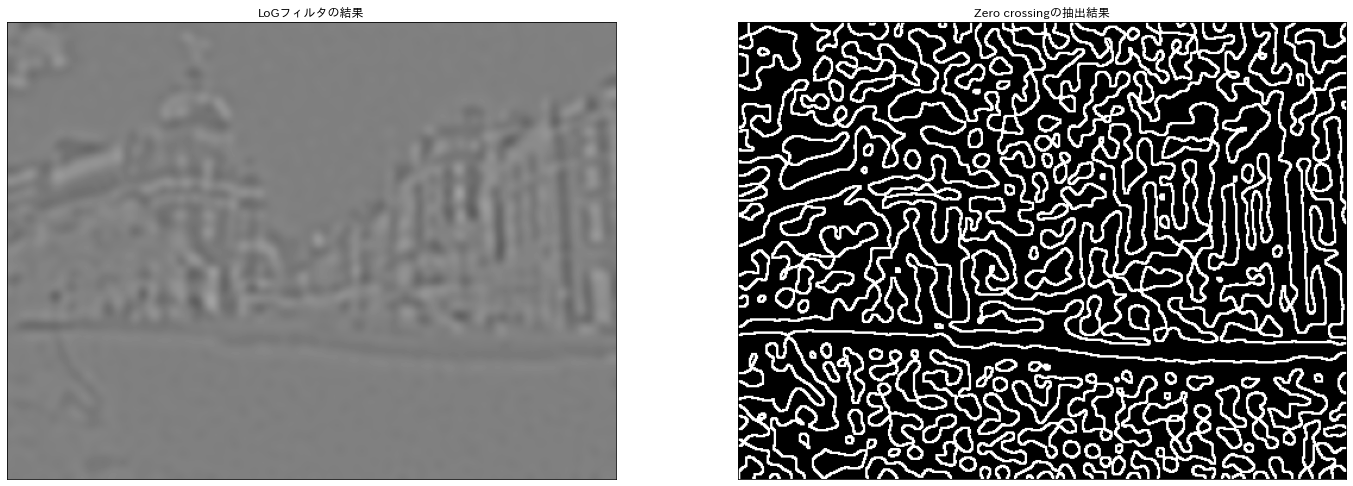

In [6]:
# SciPyのLoGを使う。出力はsignedにする
logimg = gaussian_laplace(sp_image, sigma=5, output=np.float32)
# Morphological Processingの膨張処理と収縮処理をそれぞれ最大値フィルタ，最小値フィルタとして使う
SE = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
logimg_max = cv2.dilate(logimg, kernel=SE)
logimg_min = cv2.erode(logimg, kernel=SE)
zc = ( (logimg >= 0)& (logimg_min < 0) ) | ( (logimg <= 0)& (logimg_max > 0))
plt.subplot(1,2,1)
plt.imshow(logimg, cmap='gray', vmin=-0.05, vmax=0.05)
plt.title('LoGフィルタの結果')
plt.subplot(1,2,2)
plt.imshow(zc, cmap='gray')
plt.title('Zero crossingの抽出結果');

## Cany edge detector

Cannyで実装されている。引数で2つの閾値を指定

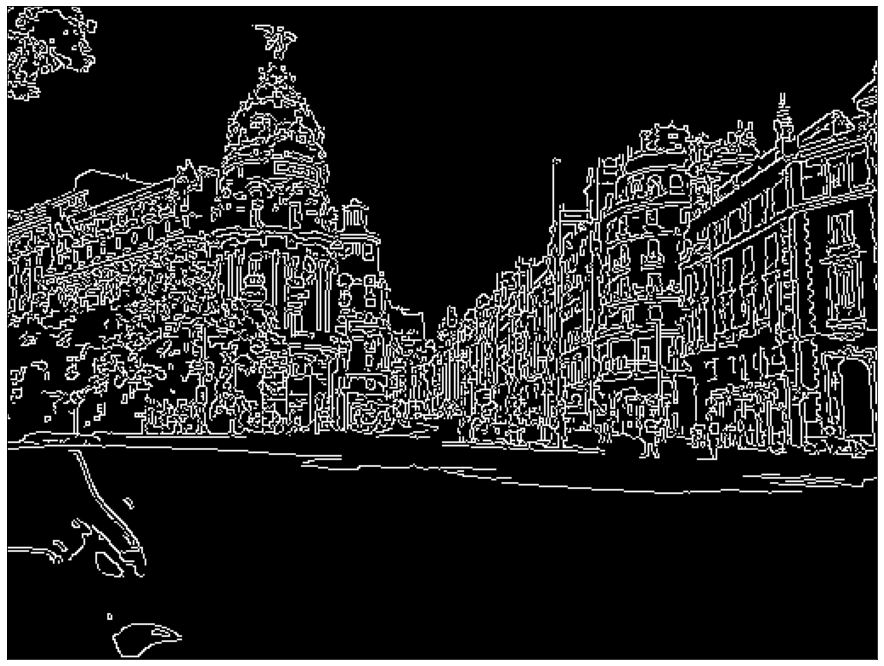

In [7]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
dst = cv2.Canny(gimg, 100, 200, apertureSize=3)
plt.imshow(dst, cmap='gray')

これもノイズ画像への処理

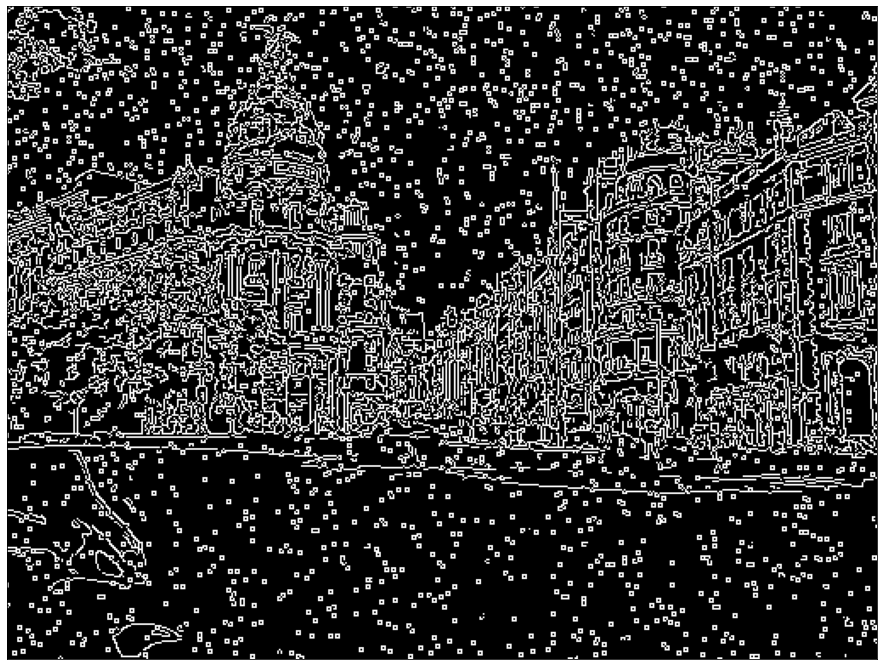

In [8]:
dst = cv2.Canny(np.uint8(sp_image*255), 100, 200, apertureSize=3)
plt.imshow(dst, cmap='gray')

## アンシャープマスキング
ガウシアンでボケさせたあとで差分をとり，原画像に加算する。


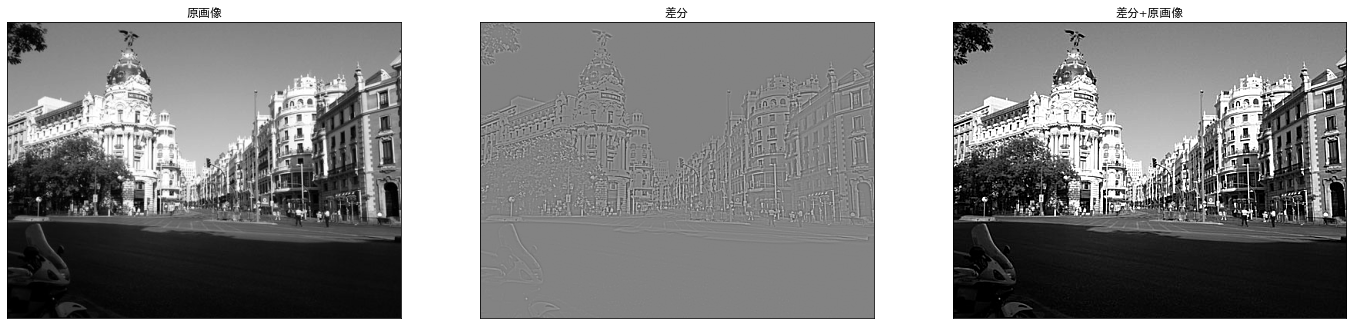

In [9]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)/255.
blur = cv2.GaussianBlur(gimg, (5, 5), 4)
diff = gimg-blur
dst = gimg+diff

plt.subplot(1,3,1)
plt.imshow(gimg, cmap='gray', vmin=0, vmax=1.0)
plt.title('原画像')
plt.subplot(1,3,2)
plt.imshow(diff, cmap='gray')
plt.title('差分')
plt.subplot(1,3,3)
plt.imshow(dst, cmap='gray', vmin=0, vmax=1.0)
plt.title('差分+原画像');


## Composite laplacian

普通にフィルタを作成してfilter2D

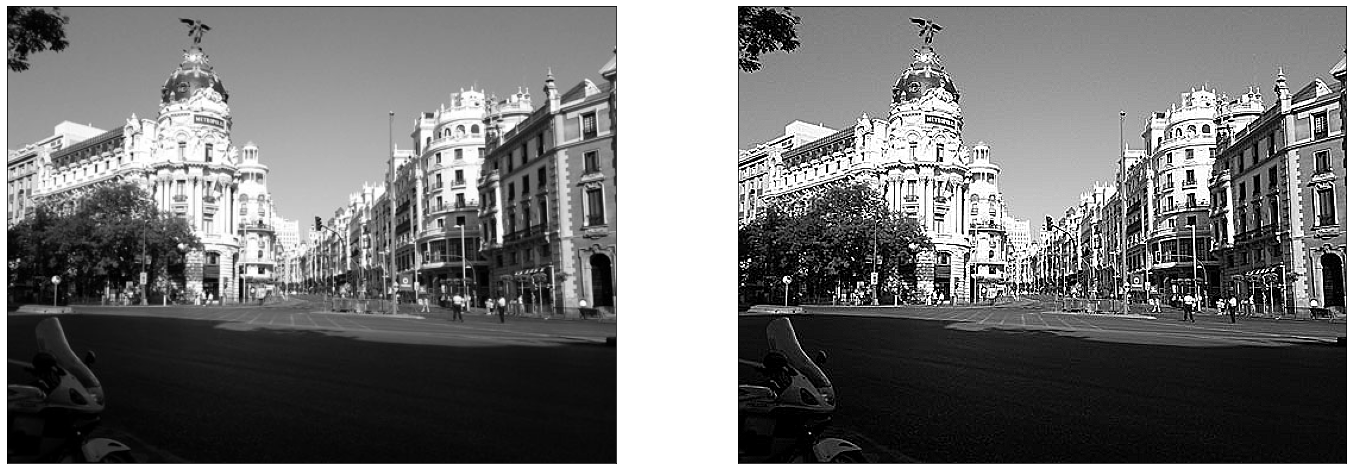

In [10]:
kern = np.array([[0, -1, 0],[-1, 5., -1], [0, -1, 0]])
dst = cv2.filter2D(gimg, -1, kern)
plt.subplot(1,2,1)
plt.imshow(gimg, cmap='gray', vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray', vmin=0, vmax=1)

## bilateral filter
部分的に表示。エッジを保持しつつディテールが平滑化されているのがわかる

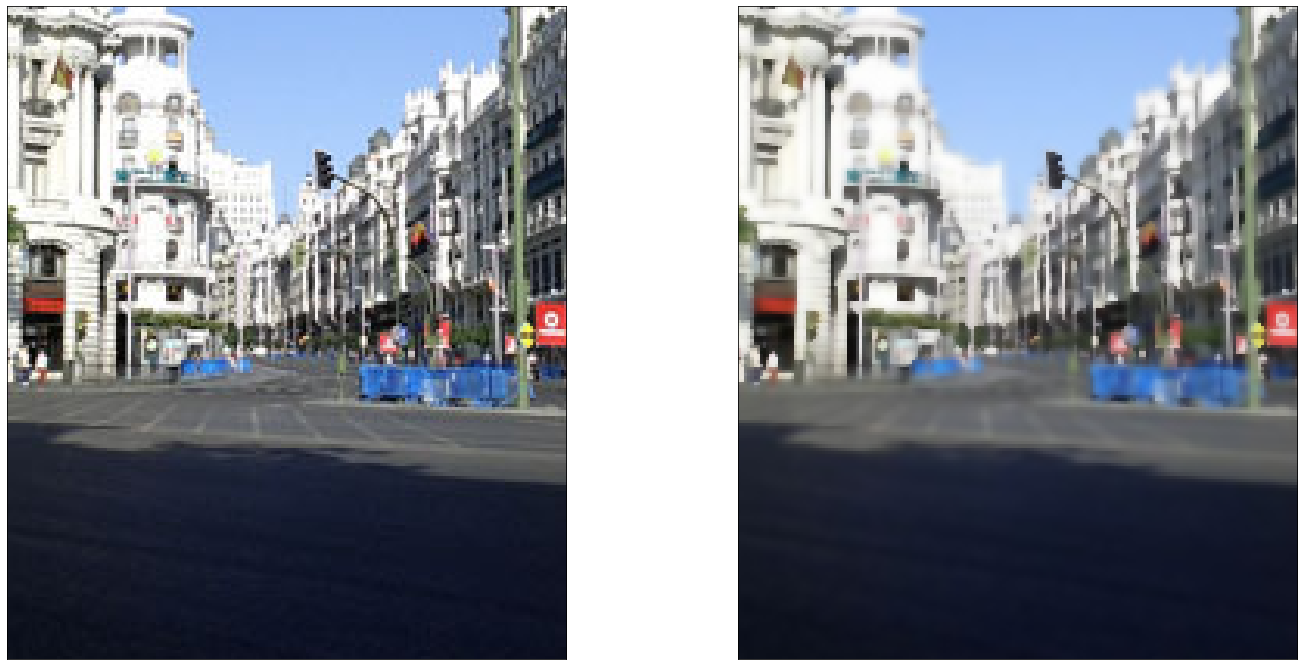

In [11]:
img = cv2.imread('sample.jpg', cv2.IMREAD_ANYCOLOR)
dst = cv2.bilateralFilter(img, 5, 170, 170)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img[130:340, 160:340,:], cv2.COLOR_BGR2RGB), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(dst[130:340, 160:340,:], cv2.COLOR_BGR2RGB), cmap='gray')

### S&Pノイズに対する挙動
局所的なS&Pに対してまんまガウシアンが乗った出力になる

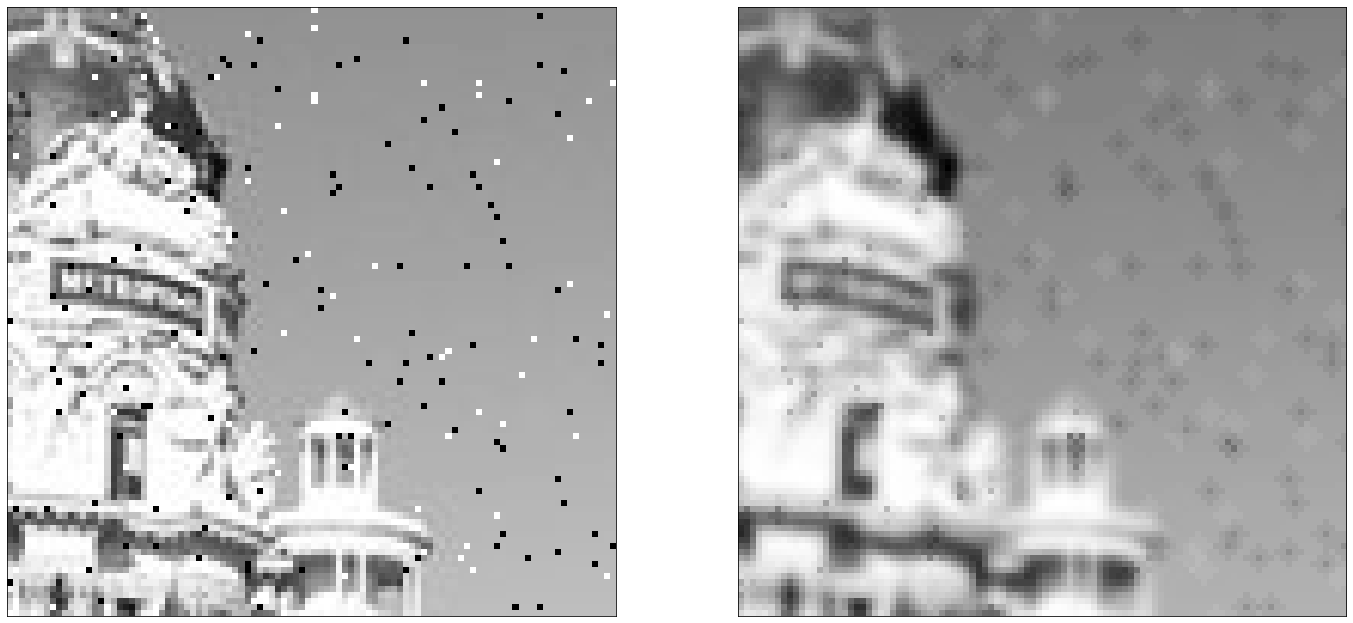

In [13]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
sp_noise = np.random.randint(0, 255, gimg.shape)
pepper = sp_noise < 3
salt = sp_noise > 252
sp_image = gimg.copy()
sp_image[pepper] = 0
sp_image[salt] = 255
dst = cv2.bilateralFilter(sp_image, 5, 170, 170)
plt.subplot(1,2,1)
plt.imshow(sp_image[50:150:, 150:250], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst[50:150, 150:250], cmap='gray')

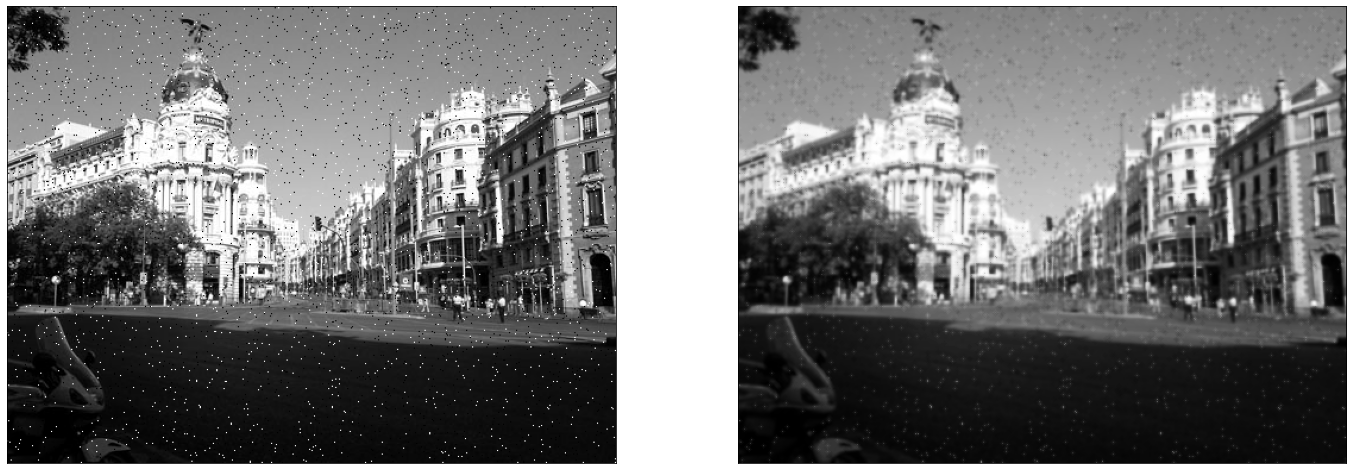

In [14]:
plt.subplot(1,2,1)
plt.imshow(sp_image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray')

## Non local means
全体的にノイズがキツい場合ほぼ平滑化の強さで決まりそうだが比較的エッジは保存されている。

In [ ]:
!wget https://github.com/eiichiromomma/CVMLAB/raw/master/img/IMG_0713.JPG


--2021-05-29 09:05:35--  https://github.com/eiichiromomma/CVMLAB/raw/master/img/IMG_0713.JPG
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/IMG_0713.JPG [following]
--2021-05-29 09:05:36--  https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/IMG_0713.JPG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231419 (226K) [image/jpeg]
Saving to: ‘IMG_0713.JPG.1’

IMG_0713.JPG.1      100%[===================>] 226.00K  --.-KB/s    in 0.06s   

2021-05-29 09:05:36 (3.46 MB/s) - ‘IMG_0713.JPG.1’ saved [231419/231419]



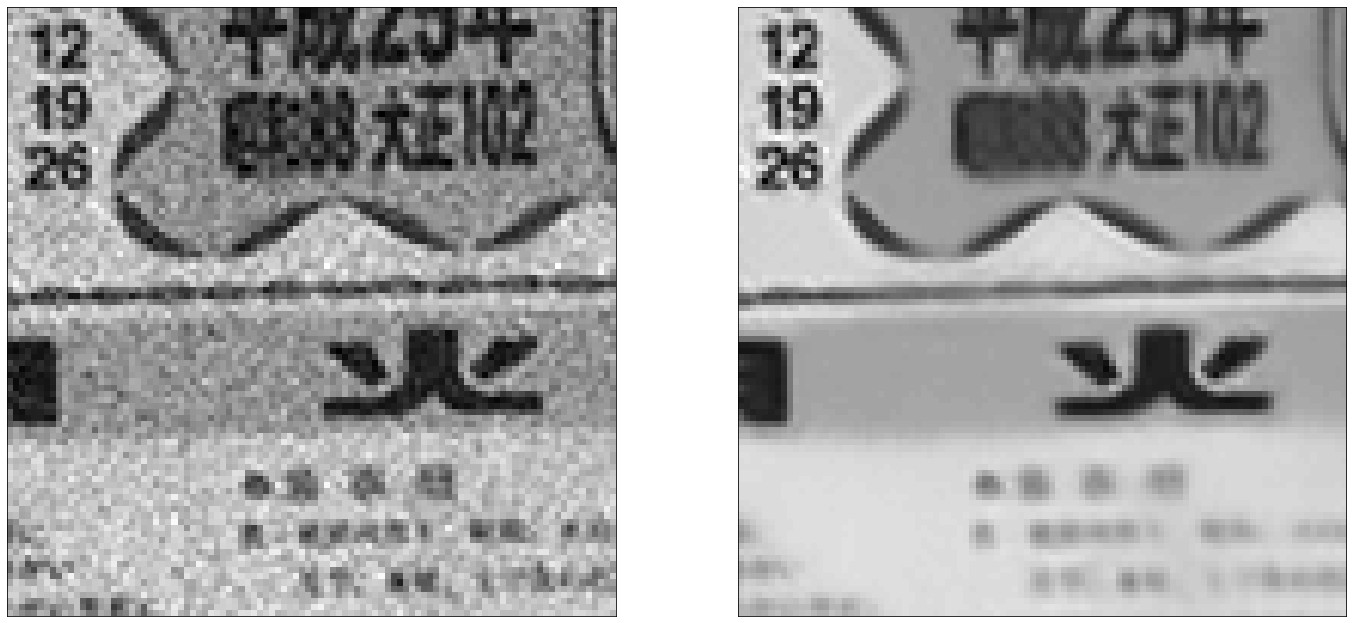

In [ ]:
gimg = cv2.imread('IMG_0713.JPG', cv2.IMREAD_GRAYSCALE)
dst = cv2.fastNlMeansDenoising(gimg, 10, 10, searchWindowSize=21, templateWindowSize=7)
plt.subplot(1,2,1)
plt.imshow(gimg[50:150:, 150:250], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst[50:150, 150:250], cmap='gray')


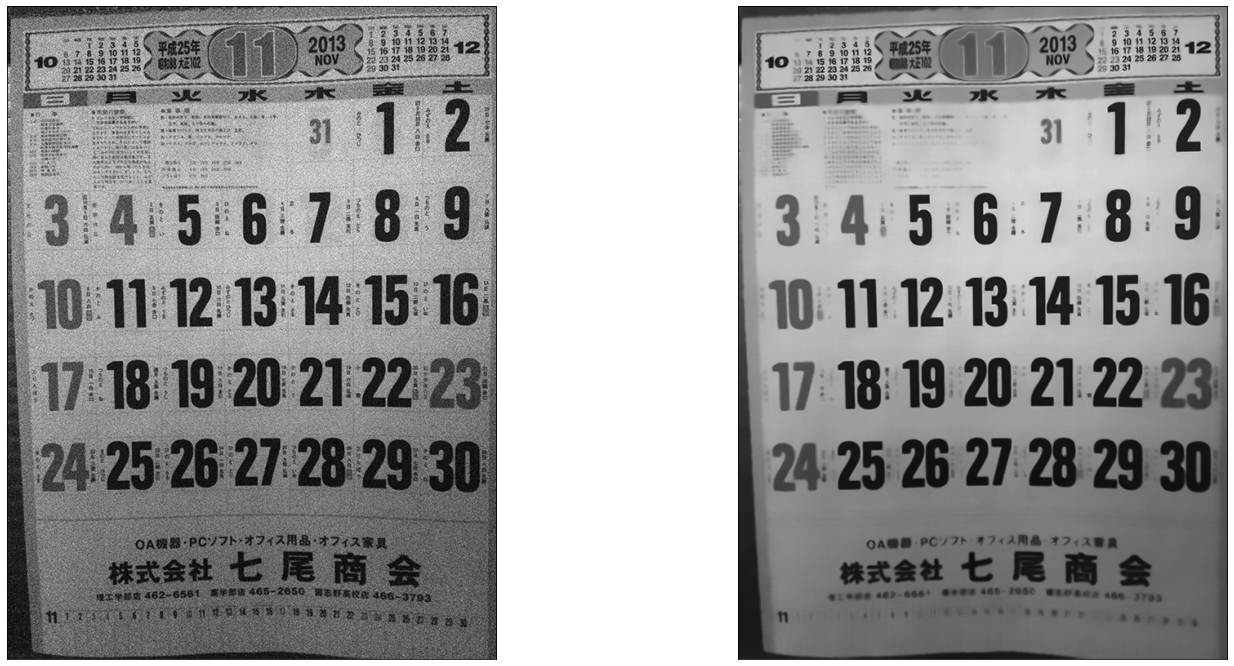

In [ ]:
plt.subplot(1,2,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray')

S&P ノイズに対しても，のっぺりとした空間なら強いがディテールのあるところは弱い。

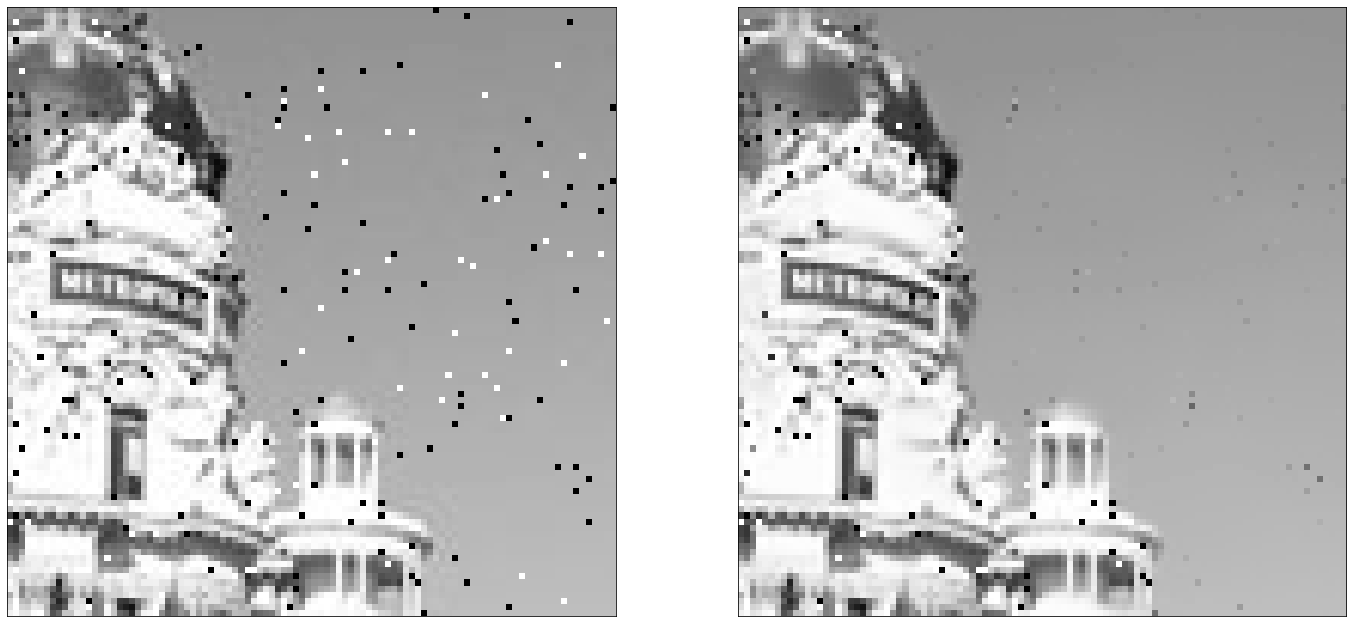

In [ ]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
sp_noise = np.random.randint(0, 255, gimg.shape)
pepper = sp_noise < 3
salt = sp_noise > 252
sp_image = gimg.copy()
sp_image[pepper] = 0
sp_image[salt] = 255
dst = cv2.fastNlMeansDenoising(sp_image, 20, 20, searchWindowSize=21, templateWindowSize=7)
plt.subplot(1,2,1)
plt.imshow(sp_image[50:150:, 150:250], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst[50:150, 150:250], cmap='gray')

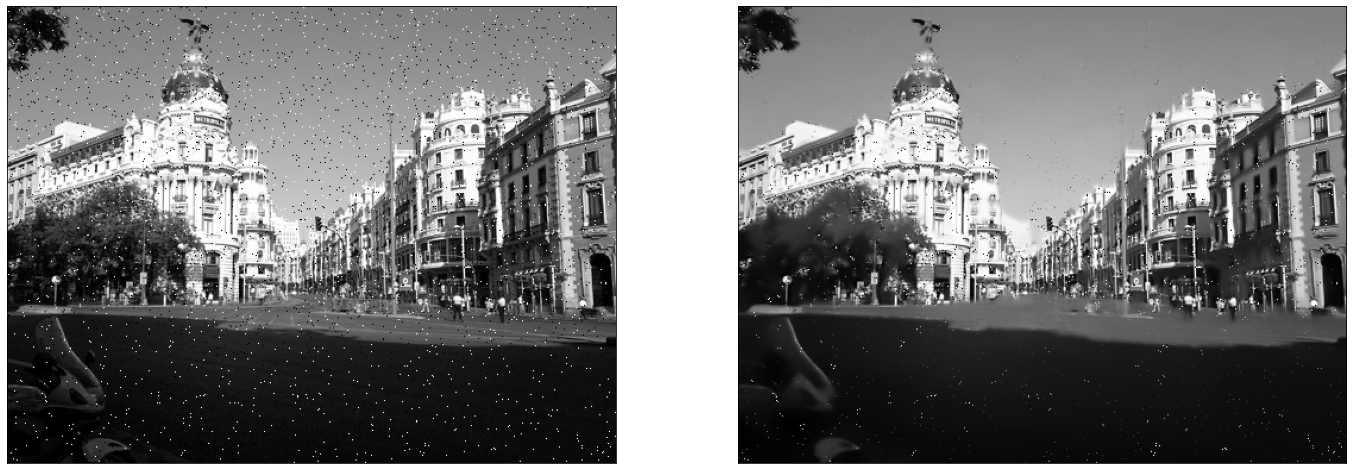

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sp_image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray')

## Median Filter

ランクフィルタ(順番入れ替え)なので計算コストは高いが外れ値のノイズには滅法強い。強度はフィルタサイズ依存

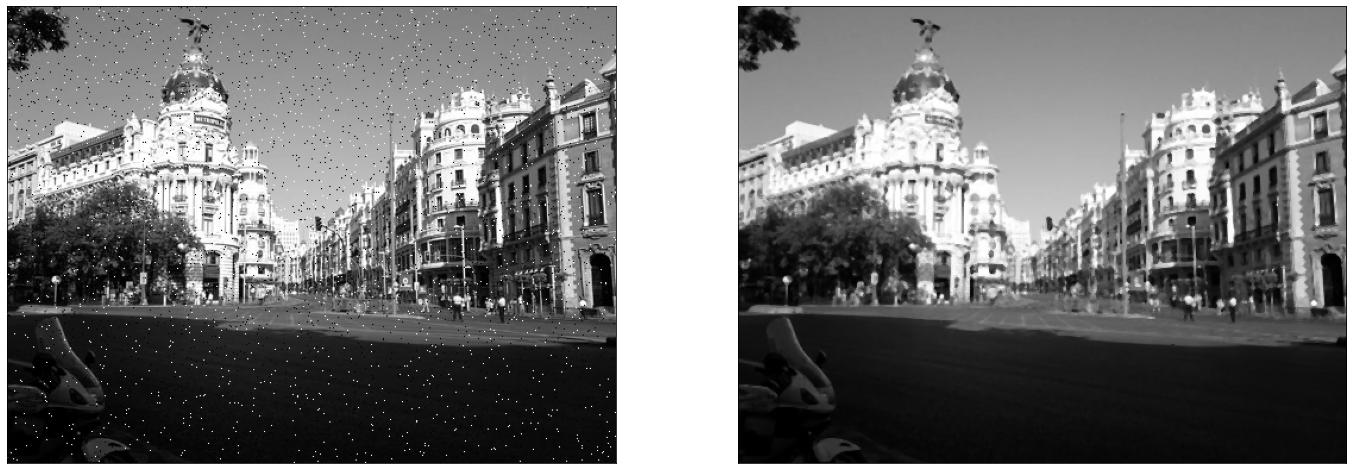

In [ ]:
dst = cv2.medianBlur(sp_image, 3)
plt.subplot(1,2,1)
plt.imshow(sp_image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray')

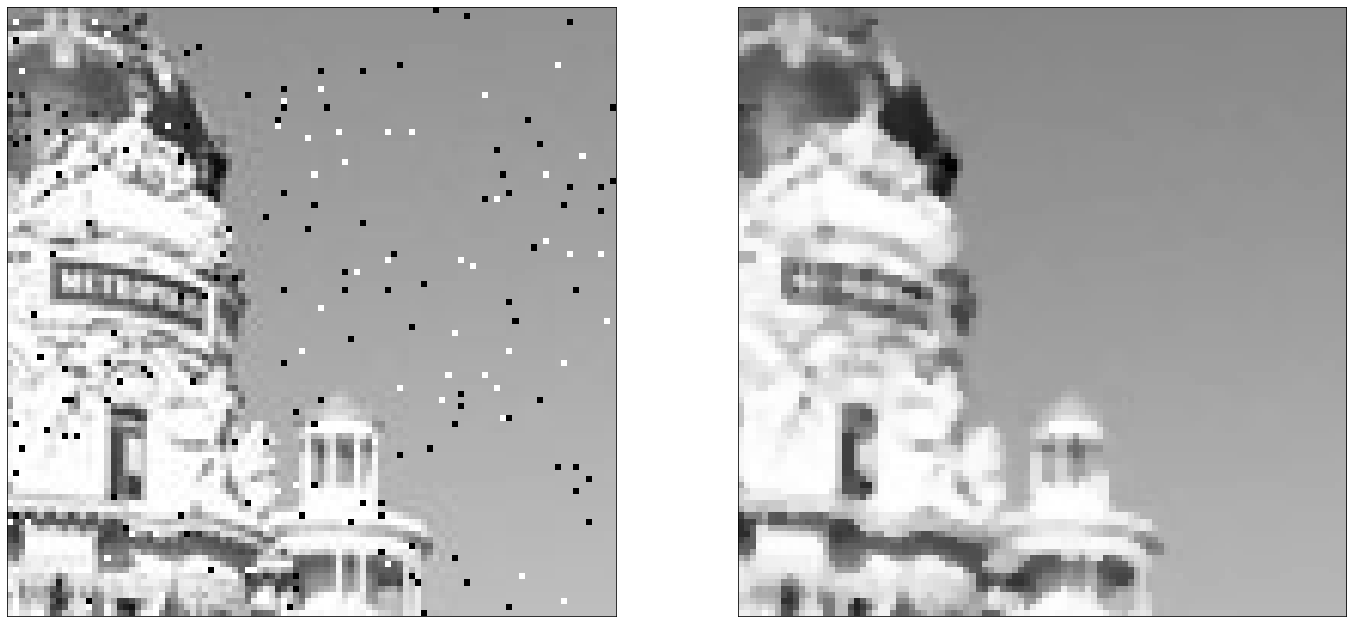

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sp_image[50:150:, 150:250], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst[50:150, 150:250], cmap='gray')

## 画像構成要素の置き換え
例えば3x3のブロックに対して平均値なりで埋めた3x3のブロックを返す処理で，要はブロック単位で代表値に置き換え，それを元のサイズに補間無しで戻せば良い。1画素ずつ結果を求めるfilter2Dと若干異なる。

scikit-imageのblock_reduceで簡単に扱える。

(77, 103)
(384, 512)


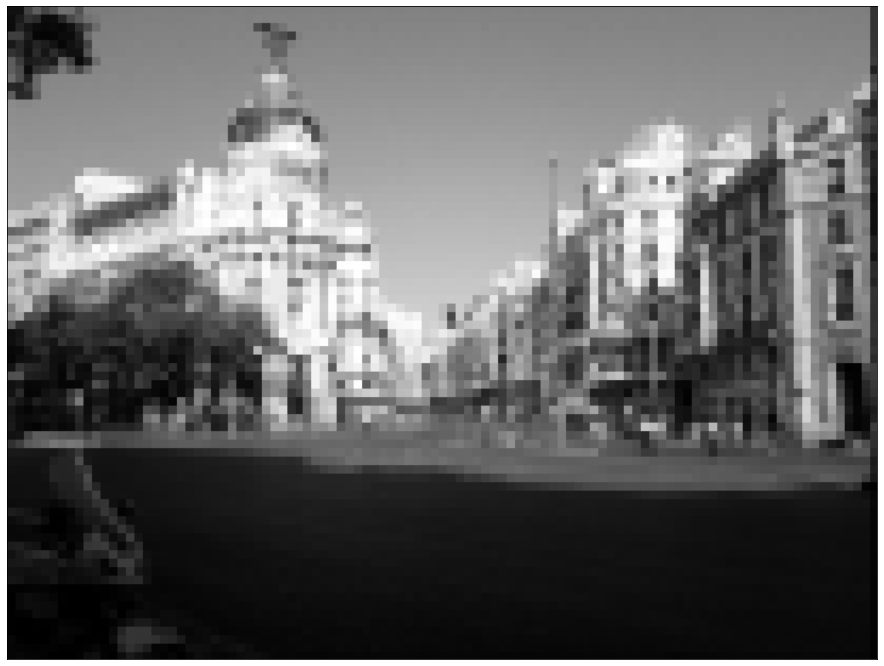

In [ ]:
from skimage.measure import block_reduce
dst = block_reduce(gimg, (5,5), np.average).astype(np.uint8)
print(dst.shape)
dst = cv2.resize(dst, gimg.shape[::-1], interpolation=cv2.INTER_NEAREST)
print(dst.shape)
plt.imshow(dst, cmap='gray')